In [37]:
import numpy as np
import matplotlib.pyplot as plt
import numba

from numba import prange

from scipy.optimize import curve_fit

from plot_functions import plot_connections, plot_poblacion
from main_functions import init_poblacion, temperatura_critica

plt.style.use(['science', 'notebook'])

# Primera aproximacion. Red cuadrada 2D.

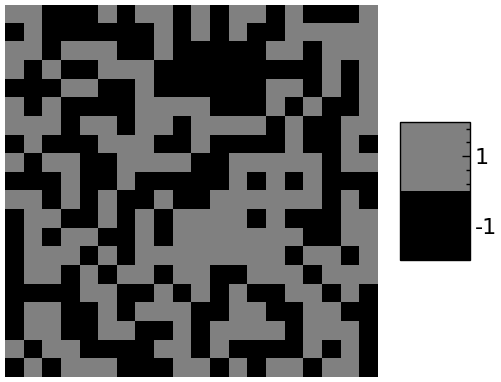

In [2]:
N = 20

lattice = np.random.random((N, N))
lattice[lattice >= .5] = 1
lattice[lattice < .5] = -1

fig, ax = plt.subplots(figsize=(6, 6))
plot_poblacion(lattice, ax)
# fig.savefig('IMAGENES/ejemplo.png')

## Algoritmo de metropolis

In [3]:
@numba.njit(nogil=True)
def metropolis(lattice, steps, T):
    """ funcion realiza una simulacion de montecarlo del modelo 
        de ising utilizando el algoritmo de metropolis
        - inputs: 
            - lattice: matrix NxN con elementos +-1
            - steps: pasos de montecarlo
            - T: temperatura del sistema
        - outputs: 
            - lattice: estado final de la red
            - spins_sum: vector 1xsteps que contiene np.sum(lattice)
    """
    lattice = lattice.copy()
    N = len(lattice)
    spins_sum = np.empty(steps)

    for step in range(steps):
        x = np.random.randint(0, N) # x in [0, 1, 2, ..., N-1]
        y = np.random.randint(0, N)
        
        spin_i = lattice[x, y]
        spin_f = -1*spin_i
        
        # calculo de la opinion de los 4 vecinos
        S = 0
        # vecinos de x
        if x==0:
            S += lattice[x+1, y]
            S += lattice[N-1, y] 
        elif x==N-1:
            S += lattice[0, y]
            S += lattice[x-1, y] 
        else:
            S += lattice[x+1, y]
            S += lattice[x-1, y] 
            
        # vecinos de y
        if y==0:
            S += lattice[x, y+1]
            S += lattice[x, N-1] 
        elif y==N-1:
            S += lattice[x, 0]
            S += lattice[x, y-1] 
        else:
            S += lattice[x, y+1]
            S += lattice[x, y-1] 
        
        
        # ver si se acepta el cambio
        if (S * spin_f > 0) or (np.random.random() < np.exp(-abs(S*spin_f)/T)):
            # condicion 1: el cambio esta a favor de la opinión de los vecinos -> S*spin_f > 0
            # condicion 2: el cambio no esta a favor pero por prob se acepta -> S*spin_f < 0 
            # ponemos el valor absoluto para mantener el sentido del modelo de ising
            lattice[x, y] = spin_f
        
        spins_sum[step] = np.sum(lattice) 
        
    return lattice, spins_sum

### Ejemplo

In [4]:
%%time
montecarlo_steps = 150000
T = 0.5
lattice_final, spins_sum = metropolis(lattice, montecarlo_steps, T)

CPU times: total: 641 ms
Wall time: 1.32 s


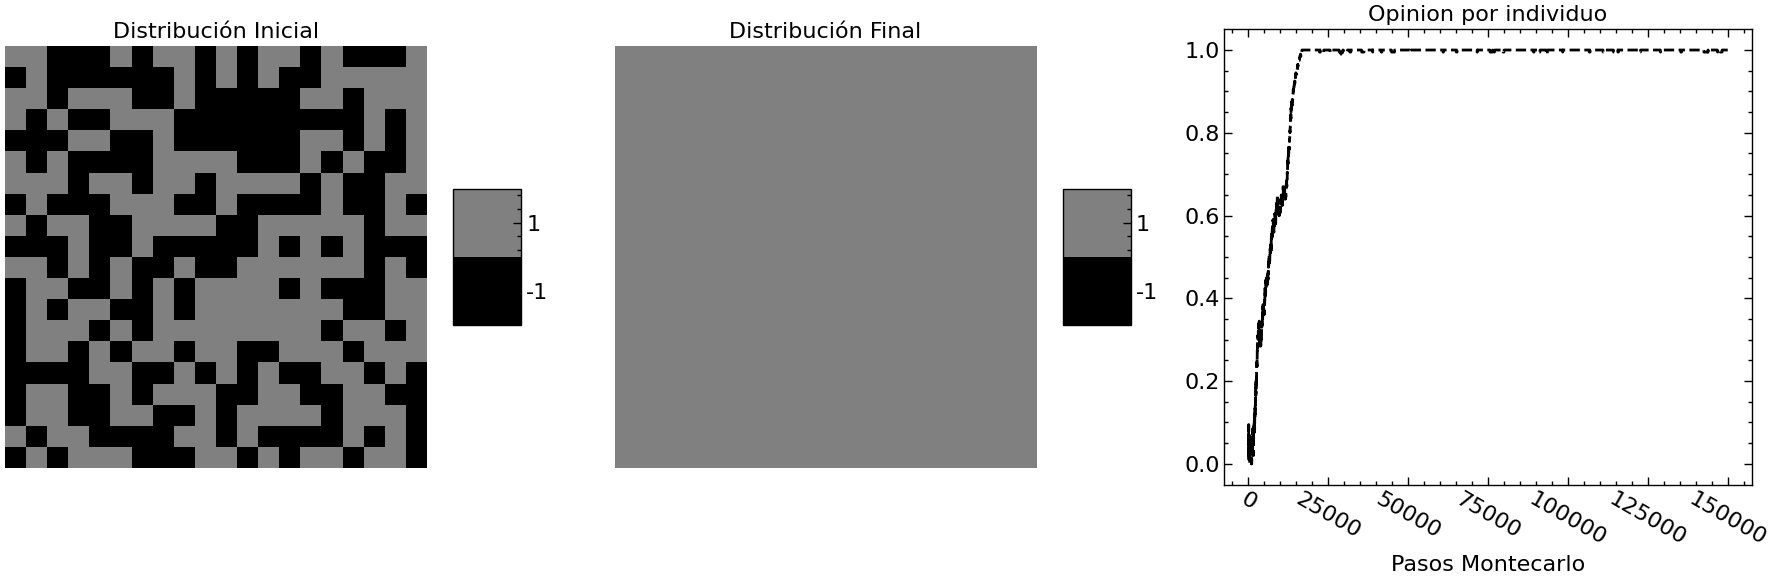

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

plot_poblacion(lattice, ax1)
ax1.set_title('Distribución Inicial')

plot_poblacion(lattice_final, ax2)
ax2.set_title('Distribución Final')

ax3.plot(spins_sum/N**2, 'k--')
plt.xticks(rotation=-30)
ax3.set_title('Opinion por individuo')
ax3.set_xlabel('Pasos Montecarlo')
plt.tight_layout()
plt.show()

In [36]:
# fig.savefig('IMAGENES/ejemplo_opinion.png')

### Pasos necesarios para alcanzar el equilibrio

In [6]:
@numba.njit(nogil=True)
def find_step(m_arr):
    """ funcion que encuentra el indice para el cual 
        se puede considerer que m se ha estabilizado 
        de acuerdo al parametro de tolerancia epsilon
        - inputs: 
            - m_arr: vector 1 x steps con la opinion por individuo
        - outputs: 
            - steps: paso tal que el sistema se ha relajado
    """
    step = 0
    epsilon = 0.0001
    for m in m_arr[1000:]:
        if abs(1 - abs(m)) < epsilon:
            return step
        step += 1

In [9]:
%%time
T = 0.5
montecarlo_steps = 5000000
N_arr = np.arange(10, 60+10, 10)
step_f = np.empty(len(N_arr))

for i, N in enumerate(N_arr):
    lattice = init_poblacion(N, 0.75)
    _, spins_sum = metropolis(lattice, montecarlo_steps, T)
    # la opinion por individuo consiste en el promedio pesado por 1/N**2
    step_f[i] = find_step(spins_sum/N**2)

CPU times: total: 47.1 s
Wall time: 50.2 s


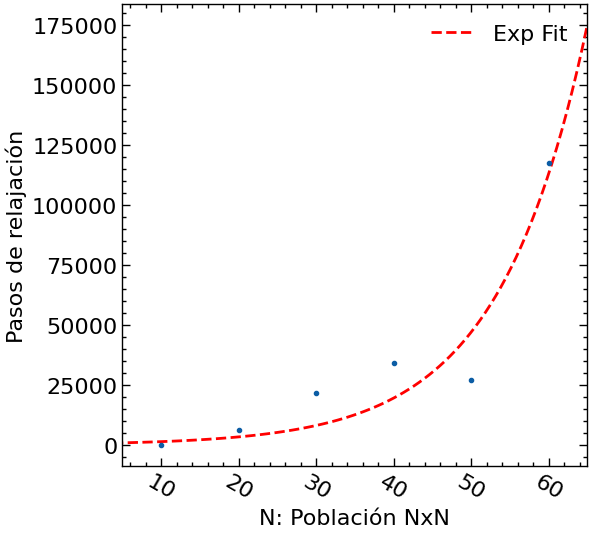

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))


def exp_func(x, a, b, c):
    return a*np.exp(-c*(x-b))

x = N_arr
y = step_f

(a, b, c), _ = curve_fit(exp_func, x, y, [50, 50, 0.001])

x = np.linspace(0, 65, 100)
ax.plot(x, exp_func(x, a, b, c), 'r--', label='Exp Fit')

ax.plot(N_arr, step_f, '.')

ax.set_ylabel('Pasos de relajación')
ax.set_xticks(N_arr)
plt.xticks(rotation=-30)
ax.set_xlabel('N: Población NxN')
ax.set_xlim([5, 65])
plt.legend()
plt.show()

In [27]:
# fig.savefig('IMAGENES/step.png')

Usaremos esta aproximación de los pasos relajacion para acelerar los cálculos usando un paso de montecarlo adecuado para cada N y no uno demasiado grande.
## Estudio de la temperatura critica 

In [11]:
@numba.njit(parallel=True, nogil=True)
def magnetizacion_T(N, prob, T_arr, steps):
    """ funcion que devuelve la magnetizacion por individuo
        una vez el sistema se ha relajado para una serie de 
        temperaturas
        - inputs: 
            - N: tamaño de la red NxN
            - prob: probabilidad que define el sesgo de la poblacion
            - T_arr: array de temperaturas
            - steps: pasos de montecarlo
        - outputs:
            - m_n: magnetizacion 1 x steps para poblacion con sesgo 
                    negativo
            - m_p: magnetizacion 1 x steps para poblacion con sesgo 
                    positivo
    """
    pob_n = init_poblacion(N, prob)
    pob_p = - pob_n.copy()

    # prealocar m
    m_n = np.empty(len(T_arr))
    m_p = np.empty(len(T_arr))

    for i in prange(len(T_arr)):
        T = T_arr[i]
        _, spins = metropolis(pob_n, steps, T)
        m_n[i] = np.mean(spins[-10000:]/N**2)
        _, spins = metropolis(pob_p, steps, T)
        m_p[i] = np.mean(spins[-10000:]/N**2)
    return m_n, m_p

In [12]:
%%time
N = 20
# pasos de montecarlo
steps = 2000000
# array de temperaturas
T_arr = np.linspace(0.01, 10)

m_n, m_p = magnetizacion_T(N, 0.75, T_arr, steps)

CPU times: total: 1min 48s
Wall time: 20.4 s


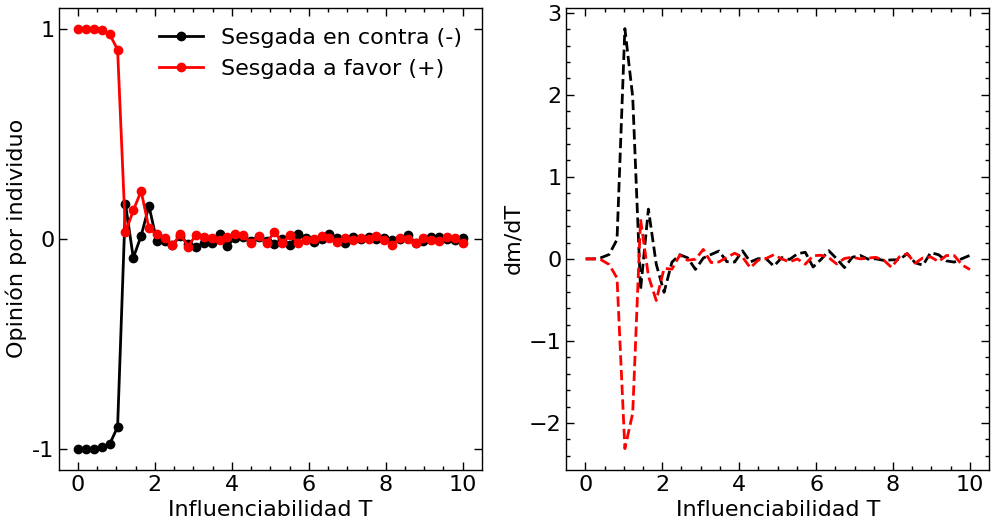

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(T_arr, m_n, 'k-o', label='Sesgada en contra (-)')
ax1.plot(T_arr, m_p, 'r-o', label='Sesgada a favor (+)')
ax1.set_xlabel('Influenciabilidad T')
ax1.set_ylabel('Opinión por individuo')
ax1.set_yticks([1, 0, -1], labels=['1', '0', '-1'])
ax1.legend()

ax2.plot(T_arr, np.gradient(m_n, T_arr), 'k--')
ax2.plot(T_arr, np.gradient(m_p, T_arr), 'r--')
ax2.set_xlabel('Influenciabilidad T')
ax2.set_ylabel('dm/dT')

plt.show()

In [10]:
# fig.savefig('IMAGENES/opinion_T.png')

Definimos la temperatura crítica como la temperatura para la cual hay un cambio de pendiente pasando de 0 a infinito (obviamente no va a ser infinito) i.e. $T_c = T \text{such} \max\{dm/dT\}$

En estas simulaciones se esta utilizando la librería de optimización numba por lo que no podemos simplemente usar np.gradient por ello se usará la derivada numérica "Diferencias centrales" como se muestra abajo la precisión es más que suficiente para un analisis cualitativo.

In [15]:
dT = T_arr[1]-T_arr[0]
dmdT_cent = (m_p[2:] - m_p[:-2]) / (2*dT)
dmdT = np.gradient(m_p, T_arr)
print(f'np.gradient               Tc(p) = {T_arr[dmdT==np.max(dmdT)][0]:.10f}')
print(f'Diferencias centrales:    Tc(p) = {T_arr[1:-1][dmdT_cent==np.max(dmdT_cent)][0]:.10f}')

dmdT_cent = (m_n[2:] - m_n[:-2]) / (2*dT)
dmdT = np.gradient(m_n, T_arr)
print(f'np.gradient               Tc(n) = {T_arr[dmdT==np.max(dmdT)][0]:.10f}')
print(f'Diferencias centrales:    Tc(n) = {T_arr[1:-1][dmdT_cent==np.max(dmdT_cent)][0]:.10f}')

np.gradient               Tc(p) = 1.4371428571
Diferencias centrales:    Tc(p) = 1.4371428571
np.gradient               Tc(n) = 1.0293877551
Diferencias centrales:    Tc(n) = 1.0293877551


### Temperatura critica promedio

In [16]:
print(f'Calculo final Tc = {temperatura_critica(T_arr, m_p, m_n):.2f}')

Calculo final Tc = 1.23


### Dependencia con N

In [17]:
%%time
@numba.njit(parallel=True, nogil=True)
def numba_op(N_arr, steps):
    """ funcion que calcula la dependencia de la 
        temperatura critica con el tamaño de la 
        poblacion NxN
        - inputs: 
            - N_arr: array con los tamaños a estudiar
            - steps: pasos de montecarlo
        - outputs: 
            - Tc_arr: temperatura critica por N dado
    """
    # array de temperaturas
    T_arr = np.linspace(0.01, 10)
    # prealocamos la Tc
    Tc = np.empty(len(N_arr))

    for i in prange(len(N_arr)):
        N = N_arr[i]
        m_n, m_p = magnetizacion_T(N, 0.75, T_arr, steps[i])
        Tc[i] = temperatura_critica(T_arr, m_p, m_n)
        print(f'N: {N} Done')
    return Tc
N_arr = np.arange(10, 50+5, 5)
# tomo dos ordenes de magnitud más por paso para asegurar 
# que la temperatura critica se calcula usando los valores
# de m YA RELAJADOS
steps = 50 * exp_func(N_arr, a, b, c)
Tc = numba_op(N_arr, steps.astype(int))

N: 10 Done
N: 15 Done
N: 20 Done
N: 25 Done
N: 30 Done
N: 35 Done
N: 40 Done
N: 45 Done
N: 50 Done
CPU times: total: 28min 36s
Wall time: 4min 24s


In [18]:
print(steps.astype(int))

[  70318  109016  169011  262023  406221  629776  976358 1513675 2346691]


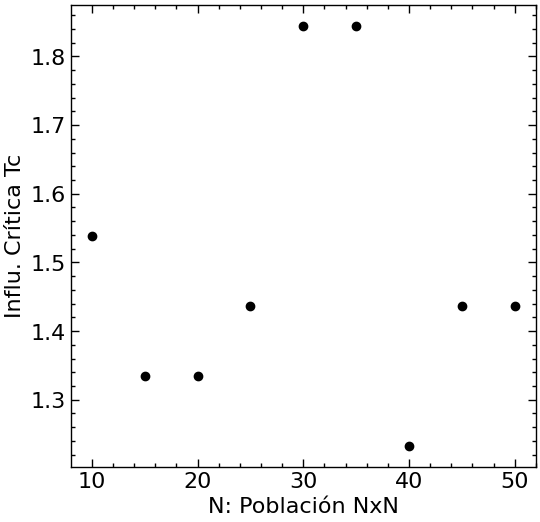

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(N_arr, Tc, 'ko')
ax.set_xlabel('N: Población NxN')
ax.set_ylabel('Influ. Crítica Tc')
plt.show()

In [20]:
# fig.savefig('IMAGENES/T_N.png')

## Estudio de la correlacion.

In [21]:
@numba.njit(nogil=True)
def metropolis_correlation(lattice, steps, T):
    """ funcion que calcula la correlacion, es una adaptacion
        del algoritmo de metropolis definido anteriormente
    """
    lattice = lattice.copy()
    N = len(lattice)
    spins_sum = np.empty(steps)
    x0, y0 = int((N-1)/2), int((N-1)/2)
    DJK = np.empty((steps, x0))
       
    for step in range(steps):
        x = np.random.randint(0, N) # x in [0, 1, 2, ..., N-1]
        y = np.random.randint(0, N)
        
        spin_i = lattice[x, y]
        spin_f = -1*spin_i
        
        # calculo de la opinion de los 4 vecinos
        S = 0
        # vecinos de x
        if x==0:
            S += lattice[x+1, y]
            S += lattice[N-1, y] 
        elif x==N-1:
            S += lattice[0, y]
            S += lattice[x-1, y] 
        else:
            S += lattice[x+1, y]
            S += lattice[x-1, y] 
            
        # vecinos de y
        if y==0:
            S += lattice[x, y+1]
            S += lattice[x, N-1] 
        elif y==N-1:
            S += lattice[x, 0]
            S += lattice[x, y-1] 
        else:
            S += lattice[x, y+1]
            S += lattice[x, y-1] 
        
        
        # ver si se acepta el cambio
        if (S * spin_f > 0) or (np.random.random() < np.exp(-abs(S*spin_f)/T)):
            # condicion 1: el cambio esta a favor de la opinión de los vecinos -> S*spin_f > 0
            # condicion 2: el cambio no esta a favor pero por prob se acepta -> S*spin_f < 0 
            # ponemos el valor absoluto para mantener el sentido del modelo de ising
            lattice[x, y] = spin_f
        
        spins_sum[step] = np.sum(lattice) 
            
        for i in range(1, x0+1):
            # correlacion
            aux = 0
            aux += lattice[x0-i, y0]*lattice[x0, y0]
            aux += lattice[x0+i, y0]*lattice[x0, y0]
            aux += lattice[x0, y0-i]*lattice[x0, y0]
            aux += lattice[x0, y0+i]*lattice[x0, y0]
            
            DJK[step, i-1] = aux/4
              
    return DJK, spins_sum


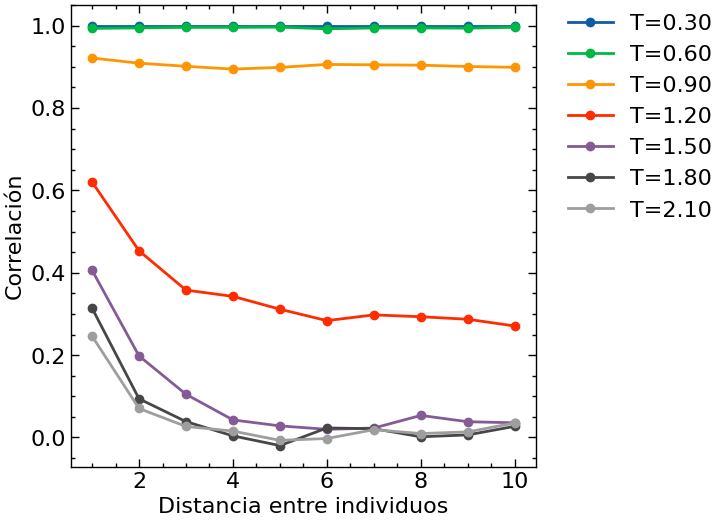

CPU times: total: 8.47 s
Wall time: 9.24 s


In [22]:
%%time
N = 21
# pasos de montecarlo
steps = 2000000
pob = init_poblacion(N, 0.75)
# array de temperaturas
# T_arr = np.linspace(0.01, 4, 8)
T_arr = np.arange(2, 15, 2) * 0.15
N_arr = np.arange(1, int((N-1)/2)+1)
fig, ax = plt.subplots(figsize=(6, 6))

for i, T in enumerate(T_arr):
    DJK, _ = metropolis_correlation(pob, steps, T)
    djk = np.mean(DJK[-500000:, :], axis=0)
    ax.plot(N_arr, djk, 'o-', label=f'T={T:.2f}')


ax.set_ylabel('Correlación')
ax.set_xlabel('Distancia entre individuos')
plt.legend(bbox_to_anchor=(1.05, 1), 
           loc='upper left', borderaxespad=0.)
plt.show()

In [23]:
# fig.savefig('IMAGENES/correlacion.png')

### Exponente critico

In [34]:
%%time
N = 21
# pasos de montecarlo
steps = 1000000


T_arr = np.linspace(0.15, 7)  
N_arr = np.arange(1, int((N-1)/2)+1)

eps_arr = np.empty(len(T_arr))


def eps_func(x, eps):
    a=1 # añadir luego lo he quitado
    return a*np.exp(-x/eps)


m = np.empty(len(T_arr))

for i, T in enumerate(T_arr):
    # poblacion positiva
    pob = -init_poblacion(N, 0.75)
    DJK, spins_sum= metropolis_correlation(pob, steps, T)
    m[i] = np.mean(spins_sum[-10000:])/N**2
    djk = np.mean(DJK[-10000:, :], axis=0)
    # print(djk)
    eps, _ = curve_fit(eps_func, N_arr, djk, [1], maxfev=5000)
    
    eps_arr[i] = eps

CPU times: total: 28 s
Wall time: 28.9 s


np.gradient               Tc(n) = 1.2683673469


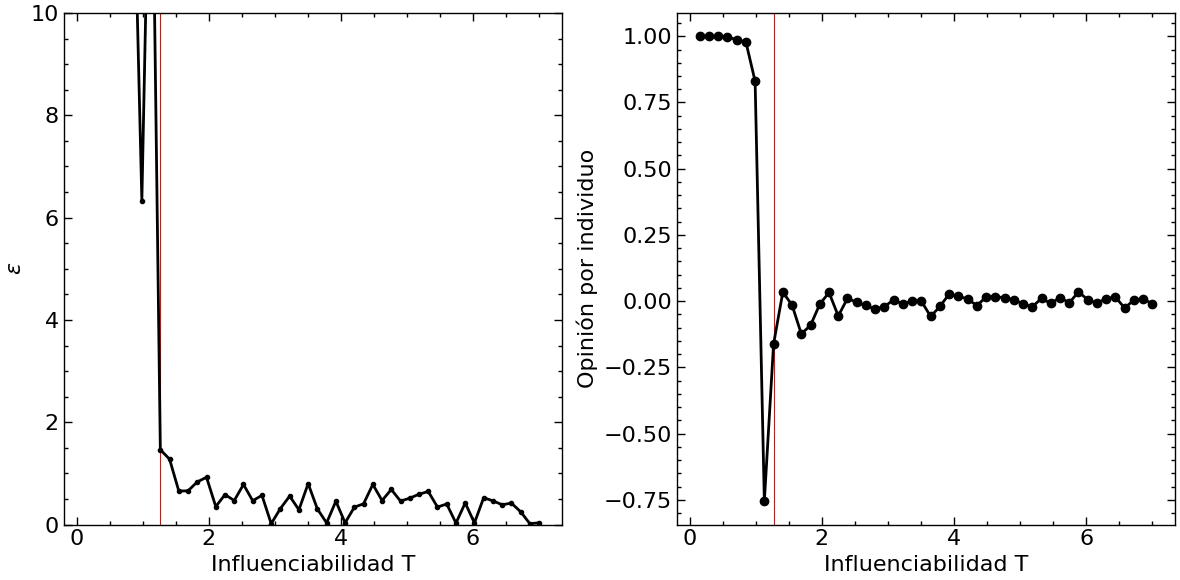

In [35]:
# Estimacion de temperatura critica
dmdT = np.gradient(m, T_arr)
print(f'np.gradient               Tc(n) = {T_arr[dmdT==np.max(dmdT)][0]:.10f}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.axvline(T_arr[dmdT==np.max(dmdT)][0], color='r', linewidth=0.8)
ax1.plot(T_arr, eps_arr, 'k.-')
ax1.set_ylim([0, 10])
ax1.set_ylabel(r'$\epsilon$')
ax1.set_xlabel('Influenciabilidad T')

ax2.axvline(T_arr[dmdT==np.max(dmdT)][0], color='r', linewidth=0.8)
ax2.plot(T_arr, m, 'ko-')
ax2.set_xlabel('Influenciabilidad T')
ax2.set_ylabel('Opinión por individuo')

plt.tight_layout()
plt.show()

In [39]:
# fig.savefig('IMAGENES/distancia_correlacion.png')

### Correlacion. Tamaños promedio de los cumulos

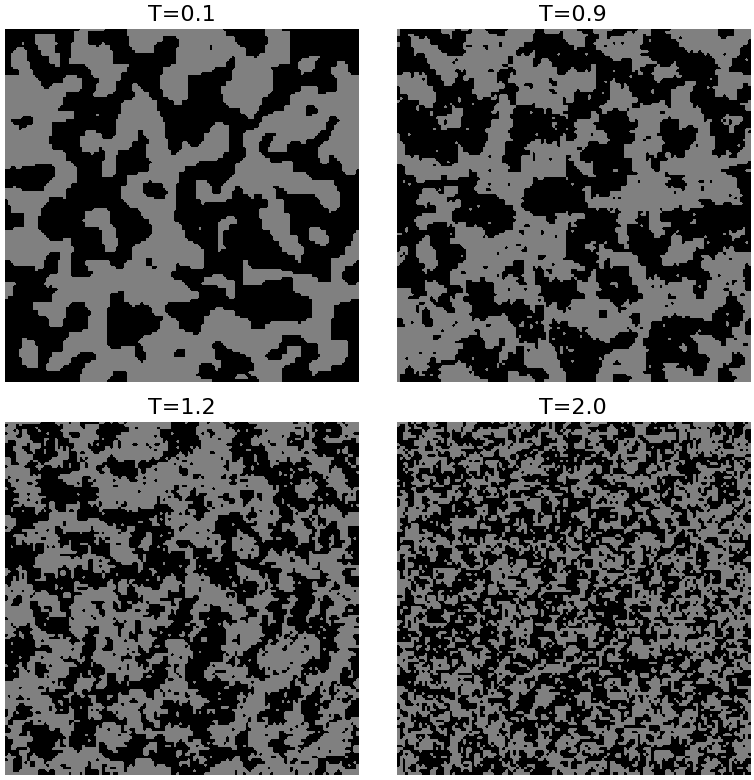

CPU times: total: 14.5 s
Wall time: 15 s


In [36]:
%%time
# Tamaño promedio de los cumulos
N = int(2**7)
montecarlo_steps = 200000
T_arr = [.1, .9, 1.2, 2.]
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i, T, in enumerate(T_arr):
    lattice = init_poblacion(N, 0.5)
    lattice_final, _ = metropolis(lattice, montecarlo_steps, T)
    plot_poblacion(lattice_final, axes.flatten()[i], cb=False)
    axes.flatten()[i].set_title(f'T={T}')
plt.tight_layout()
plt.show()

In [6]:
# fig.savefig('IMAGENES/tamaño_cumulo.png')